## 2. Gradient Descent

### 2.1 Load Llama and Pass Sample Text Through

In [1]:
import torch
from torch.nn import functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device='cuda'
model_id = "meta-llama/Llama-3.2-1B"

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [4]:
text = "The capital of France is"
inputs = tokenizer(text, return_tensors="pt").to(device)

In [5]:
inputs

{'input_ids': tensor([[128000,    791,   6864,    315,   9822,    374]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [6]:
#Tokenizer prepends a speical <|begin_of_text|> token
for input_token_index in inputs['input_ids'].view(-1):
    print(input_token_index.item(), tokenizer.decode(input_token_index))

128000 <|begin_of_text|>
791 The
6864  capital
315  of
9822  France
374  is


In [7]:
#Pass inputs into model
with torch.no_grad():
    outputs=model(inputs["input_ids"])

In [8]:
#One output vector for each input token, each vector has one value for each token in Llama's 128256 token vocabulary
outputs.logits.shape 

torch.Size([1, 6, 128256])

In [9]:
probabilities=F.softmax(outputs.logits, dim=-1) #Convert to probabilities (more on this in Ch. 3)
probabilities.shape

torch.Size([1, 6, 128256])

In [10]:
#Just look at final vector to see what text the model predicts next
top_probs, top_indices = torch.topk(probabilities[0, -1, :], 10)
for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
    print(idx.item(), round(probabilities[0, -1, idx].item(),5), tokenizer.decode([idx]))

12366 0.39153  Paris
264 0.08419  a
279 0.0704  the
832 0.03096  one
1101 0.03061  also
2162 0.02528  home
3967 0.02462  known
539 0.01659  not
459 0.01241  an
7559 0.01172  located


In [11]:
# For comparison, here's the top results for the 4th position, 
# these are the models predictions after "The Capital of" - Interesting that France makes the top 10 list!
top_probs, top_indices = torch.topk(probabilities[0, 3, :], 10)
for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
    print(idx.item(), round(probabilities[0, 3, idx].item(),5), tokenizer.decode([idx]))

279 0.20471  the
1561 0.01653  New
6890 0.01426  India
4987 0.01425  South
9822 0.01127  France
5734 0.00979  China
8524 0.0095  Russia
18157 0.00935  Spain
12550 0.00887  Mexico
16272 0.00872  Georgia


### 2.2 How does our model's confidence in Paris change as we modify a specific weight?

In [12]:
param_dict = {name: param for name, param in model.named_parameters()}
len(param_dict) #Our llama model contains 146 separate parameter tensors

146

In [13]:
#Quick look at the sizes of the first tensors
for k, v in list(param_dict.items())[:16]:
    print(k, v.shape)

model.embed_tokens.weight torch.Size([128256, 2048])
model.layers.0.self_attn.q_proj.weight torch.Size([2048, 2048])
model.layers.0.self_attn.k_proj.weight torch.Size([512, 2048])
model.layers.0.self_attn.v_proj.weight torch.Size([512, 2048])
model.layers.0.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.0.mlp.gate_proj.weight torch.Size([8192, 2048])
model.layers.0.mlp.up_proj.weight torch.Size([8192, 2048])
model.layers.0.mlp.down_proj.weight torch.Size([2048, 8192])
model.layers.0.input_layernorm.weight torch.Size([2048])
model.layers.0.post_attention_layernorm.weight torch.Size([2048])
model.layers.1.self_attn.q_proj.weight torch.Size([2048, 2048])
model.layers.1.self_attn.k_proj.weight torch.Size([512, 2048])
model.layers.1.self_attn.v_proj.weight torch.Size([512, 2048])
model.layers.1.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.1.mlp.gate_proj.weight torch.Size([8192, 2048])
model.layers.1.mlp.up_proj.weight torch.Size([8192, 2048])


In [14]:
#We're going to modify a parameter in the final MLP layer
param_dict['model.layers.15.mlp.down_proj.weight'].shape 

torch.Size([2048, 8192])

In [15]:
#Print this parameters current value. 
initial_value=param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item()
initial_value

-0.007080078125

In [16]:
text = "The capital of France is"
inputs = tokenizer(text, return_tensors="pt").to(device)

In [17]:
#Sanity check that if replace our parameter with it's current value we get the same answer
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value
    with torch.no_grad():
        outputs=model(inputs["input_ids"])
    probs=F.softmax(outputs.logits.detach().cpu(), dim=-1)
    loss=-np.log(probs[0, -1, 12366].item()) #12366 is Paris token index
    print(param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item(), probs[0, 5, 12366].item(), loss)

-0.007080078125 0.391557902097702 0.9376218764087003


In [18]:
#Decrease our parameter, how does our models prediction change?
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value-0.01
    with torch.no_grad():
        outputs = model(inputs["input_ids"])
    probs=F.softmax(outputs.logits.detach().cpu(), dim=-1)
    loss=-np.log(probs[0, -1, 12366].item())
    print(param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item(), probs[0, 5, 12366].item(), loss)

-0.017080077901482582 0.39008358120918274 0.9413942520269462


In [19]:
#Increase our parameter, how does our models prediction change?
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value+0.01
    with torch.no_grad():
        outputs = model(inputs["input_ids"])
    probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
    loss=-np.log(probs[0, -1, 12366].item())
    print(param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788].item(), probs[0, 5, 12366].item(), loss)

0.0029199218843132257 0.3930262625217438 0.9338788435905439


In [20]:
# Now test range of values for our parameter
xs=np.arange(-1, 4, 0.01)
model.eval()
losses=[]; all_probs=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=x
        outputs = model(inputs["input_ids"])
        probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, -1, 12366])
        losses.append(my_loss.item())
        all_probs.append(probs[0, -1, 12366].item())

  0%|                                            | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2110256/1879869523.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, -1, 12366])
100%|██████████████████████████████████| 500/500 [00:11<00:00, 45.15it/s]


Text(0.5, 0, 'Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

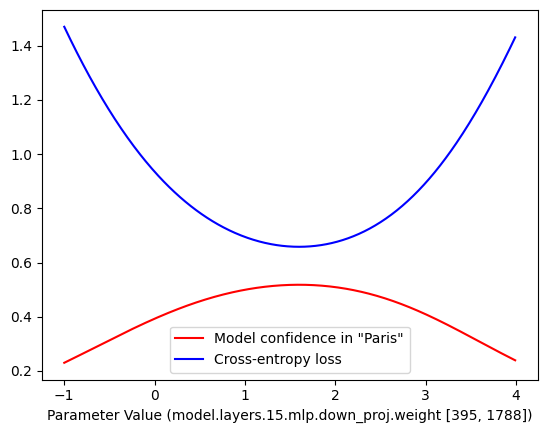

In [21]:
plt.plot(xs, all_probs, color='red'); plt.plot(xs, losses, color='blue')
plt.legend(['Model confidence in "Paris"', 'Cross-entropy loss'])
plt.xlabel('Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

In [22]:
#What paramter value minimizes our loss?
xs[np.argmin(losses).item()]

np.float64(1.5900000000000025)

In [23]:
#Return model to its original setup
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=initial_value

### 2.3 Let's Try Learning One Parameter At a Time

In [24]:
#Set our first parameter to the optimal value we found in 2.2
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=1.59

In [25]:
# Now test range of values for a second parameter
xs=np.arange(-1, 4, 0.01)
model.eval()
losses_2=[]; all_probs_2=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict['model.layers.15.mlp.down_proj.weight'][1671, 1788]=x #Second parameter was also chosen due to high gradient.
        outputs = model(inputs["input_ids"])
        probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, -1, 12366])
        losses_2.append(my_loss.item())
        all_probs_2.append(probs[0, -1, 12366].item())

  0%|                                            | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2110256/4198674048.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, -1, 12366])
100%|██████████████████████████████████| 500/500 [00:11<00:00, 44.51it/s]


Text(0.5, 0, 'Parameter Value (model.layers.15.mlp.down_proj.weight [1671, 1788])')

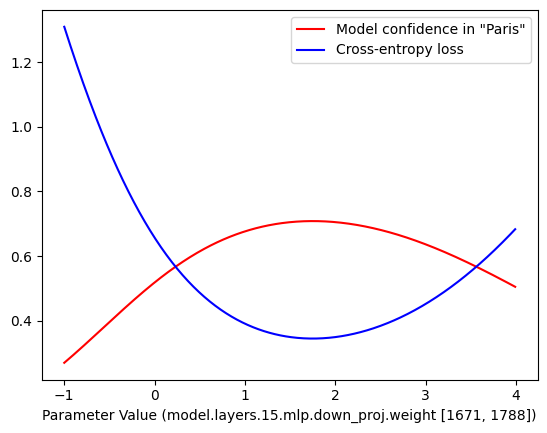

In [30]:
plt.plot(xs, all_probs_2, color='red'); plt.plot(xs, losses_2, color='blue')
plt.legend(['Model confidence in "Paris"', 'Cross-entropy loss'])
plt.xlabel('Parameter Value (model.layers.15.mlp.down_proj.weight [1671, 1788])')

In [31]:
#What paramter value minimizes our loss?
xs[np.argmin(losses_2).item()]

np.float64(1.7500000000000027)

In [28]:
#Set our second parameter to it's optimal value
with torch.no_grad():
    param_dict['model.layers.15.mlp.down_proj.weight'][1671, 1788]=1.75

In [29]:
# Now we get into a pickle, let's test our first parameter again
xs=np.arange(-1, 4, 0.01)
model.eval()
losses_b=[]; all_probs_b=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict['model.layers.15.mlp.down_proj.weight'][395, 1788]=x
        outputs = model(inputs["input_ids"])
        probs = F.softmax(outputs.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, -1, 12366])
        losses_b.append(my_loss.item())
        all_probs_b.append(probs[0, -1, 12366].item())

  0%|                                            | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2110256/2084474677.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, -1, 12366])
100%|██████████████████████████████████| 500/500 [00:11<00:00, 44.69it/s]


Text(0.5, 0, 'Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

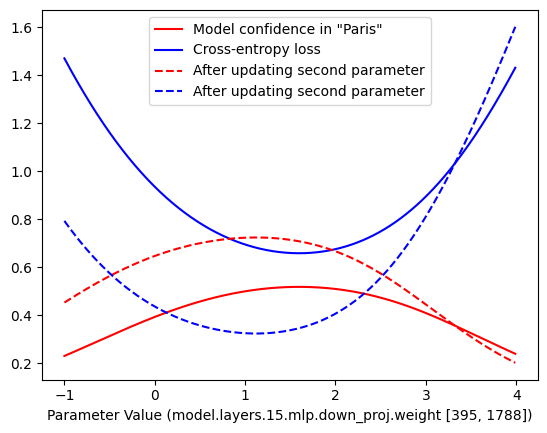

In [33]:
plt.plot(xs, all_probs, color='red'); plt.plot(xs, losses, color='blue')
plt.plot(xs, all_probs_b, 'r--'); plt.plot(xs, losses_b, 'b--')
plt.legend(['Model confidence in "Paris"', 'Cross-entropy loss', 'After updating second parameter', 'After updating second parameter'])
plt.xlabel('Parameter Value (model.layers.15.mlp.down_proj.weight [395, 1788])')

In [36]:
# Ah, the shape of our second curve has changed! 
# What value for our first parameter minimizes our loss now?
xs[np.argmin(losses_b).item()]

np.float64(1.1200000000000019)

### 2.4 Explore Loss Landscape For Randomly Initialized Model

In [1]:
import torch
from torch.nn import functional as F
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [2]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

In [3]:
#Only needed for llama random initialization
config_dict = {
  "_attn_implementation_autoset": True,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": False,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": False,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": True,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "use_cache": True,
  "vocab_size": 128256
}

In [4]:
device='cuda'
model_id = "meta-llama/Llama-3.2-1B"

torch.manual_seed(42)
np.random.seed(42)

model_config  = LlamaConfig.from_dict(config_dict)
model = LlamaForCausalLM(model_config).to(device) 
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

In [5]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [6]:
fig=plt.figure(0, (10, 5))
for fig_count, random_seed in enumerate([64, 51]):
    filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
    filtered_params = filtered_params[1:] #Leave off embedding layer
    
    direction1 = get_random_directions(filtered_params, seed=random_seed)
    direction1 = normalize_direction(direction1, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    num_points=4096
    alphas=np.linspace(-2.5, 2.5, num_points)
    
    losses=[]
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            for name, param in model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name]
            
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)
            paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
            losses.append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    fig.add_subplot(1,2,fig_count+1)
    plt.plot(alphas, losses)
    plt.xlabel('$\alpha$'); plt.ylabel('Loss')
    
save_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/ai_book/2_backprop_1/design/asset'
plt.savefig(save_dir+'/before_training_landscape_slice_'+str(random_seed)+'.svg')

NameError: name 'random_seed_1' is not defined

<Figure size 1000x500 with 0 Axes>

## Scratch/Hacking

In [5]:


my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


In [6]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

3.3751838207244873 3.3751838207244873 0.9376916737061879


In [7]:
my_probs.shape

torch.Size([1, 7, 128256])

In [9]:
sI=np.argsort(my_probs[0,5, :].detach().cpu().float().numpy())[::-1]

for i in sI[:10]:
    print(i, round(my_probs[0, 5, i].item(),5), tokenizer.decode([i]))

12366 0.39153  Paris
264 0.08419  a
279 0.0704  the
832 0.03096  one
1101 0.03061  also
2162 0.02528  home
3967 0.02462  known
539 0.01659  not
459 0.01241  an
7559 0.01172  located


In [10]:
# for i in range(12350, 12380):
#     print(tokenizer.decode(i))